# 2 - Genotyping quality control and Principal Component Analysis (PCA) 

In [1]:
from matplotlib_venn import venn3
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import subprocess
import math
import sys
import os

## Introduction

During this step, we will perform quality control (QC) on merged genotyping data. QC is a fundamental step of every GWA study. Raw genotyping data contains errors, such as contaminations, poor quality of DNA samples or poor hybridization on genotyping array. Therefore, without QC GWAS probably would return unreliable results.

During QC we will filter genotyping data for:

- **sex discrepancies**

- **SNPs with A/T and C/G**

- **SNP missingness rate**

- **genotyping missingness rate**

- **minor allele frequency (MAF)**

- **deviations from Hardy-weinberg equilibrium (HWE)**

After QC, we will analyze population stratification.

In [2]:
ppmi_merge_fn = "../../data/genotyping/PPMI_merge"
ppmi_merge_bim_fn = "../../data/genotyping/PPMI_merge.bim"

### Exploring the merged SNP dataset

In [3]:
ppmi_merge_bim = pd.read_csv(ppmi_merge_bim_fn, sep="\t", header=None)
ppmi_merge_bim.head(n=10)

,0,1,2,3,4,5
0,1,1:762320_T_C,0,762320,T,C
1,1,1:861349_0_C,0,861349,0,C
2,1,1:865545_0_0,0,865545,0,0
3,1,1:865584_0_G,0,865584,0,G
4,1,1:865625_0_G,0,865625,0,G
5,1,1:865628_A_G,0,865628,A,G
6,1,1:865662_0_G,0,865662,0,G
7,1,1:865665_A_G,0,865665,A,G
8,1,1:865694_T_C,0,865694,T,C
9,1,1:865700_0_C,0,865700,0,C


In [4]:
ppmi_merge_bim.shape  # 452102 SNPs

(452102, 6)

## Quality Control

### Individual and SNP missingness

*---- Description ----*

In [6]:
!plink --bfile {ppmi_merge_fn} --missing --out {ppmi_merge_fn}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_merge.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_merge
  --missing
  --out ../../data/genotyping/PPMI_merge

16384 MB RAM detected; reserving 8192 MB for main workspace.
452102 variants loaded from .bim file.
520 people (341 males, 179 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 520 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
../../data/genotyping/PPMI_merge.hh ); many commands treat these as missing.
treat these as missing.
Total genotyping rate is 0.958159.
--missing: Sample missing data report writ

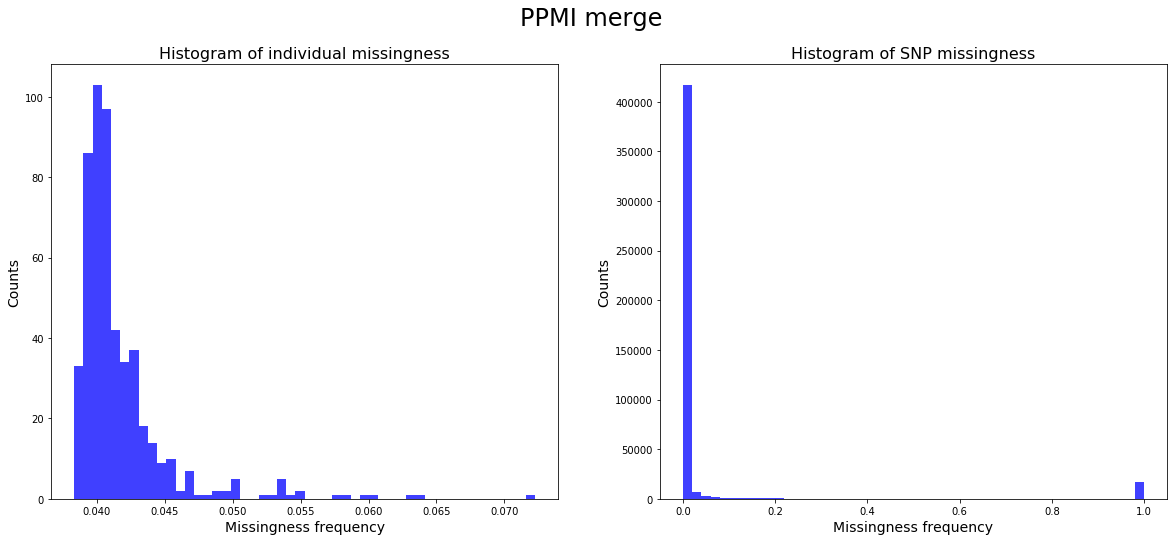

In [7]:
ppmi_indmiss = pd.read_csv(
    ".".join([ppmi_merge_fn, "imiss"]),
    sep="\s+"
)
ppmi_snpmiss = pd.read_csv(
    ".".join([ppmi_merge_fn, "lmiss"]),
    sep="\s+"
)

f, axes = plt.subplots(1,2, figsize=(20,8))
n, bins, patches = axes[0].hist(
    ppmi_indmiss.F_MISS.tolist(),
    50,
    facecolor="blue",
    alpha=.75
)
axes[0].set_xlabel("Missingness frequency", size=14)
axes[0].set_ylabel("Counts", size=14)
axes[0].set_title("Histogram of individual missingness", size=16)
n, bins, patches = axes[1].hist(
    ppmi_snpmiss.F_MISS.tolist(), 
    50,
    facecolor="blue", 
    alpha=.75
)
axes[1].set_xlabel("Missingness frequency", size=14)
axes[1].set_ylabel("Counts", size=14)
axes[1].set_title("Histogram of SNP missingness", size=16)
plt.suptitle("PPMI merge", size=24)
plt.show()

In [8]:
!plink --bfile {ppmi_merge_fn} --geno 0.05 --make-bed --out {"_".join([ppmi_merge_fn, "geno"])}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_merge_geno.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_merge
  --geno 0.05
  --make-bed
  --out ../../data/genotyping/PPMI_merge_geno

16384 MB RAM detected; reserving 8192 MB for main workspace.
452102 variants loaded from .bim file.
520 people (341 males, 179 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 520 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
../../data/genotyping/PPMI_merge_geno.hh ); many commands treat these as
missing.
treat these as missing.
Total genotyping rate is 0.958159.
25994 varian

In [9]:
!plink --bfile {"_".join([ppmi_merge_fn, "geno"])} --mind 0.05 --make-bed --out {"_".join([ppmi_merge_fn, "mind"])}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_merge_mind.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_merge_geno
  --make-bed
  --mind 0.05
  --out ../../data/genotyping/PPMI_merge_mind

16384 MB RAM detected; reserving 8192 MB for main workspace.
426108 variants loaded from .bim file.
520 people (341 males, 179 females) loaded from .fam.
0 people removed due to missing genotype data (--mind).
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 520 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
../../data/genotyping/PPMI_merge_mind.hh ); many commands treat these as
missing.
treat thes

In [11]:
!plink --bfile {"_".join([ppmi_merge_fn, "mind"])} --missing --out {"_".join([ppmi_merge_fn, "mind"])}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_merge_mind.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_merge_mind
  --missing
  --out ../../data/genotyping/PPMI_merge_mind

16384 MB RAM detected; reserving 8192 MB for main workspace.
426108 variants loaded from .bim file.
520 people (341 males, 179 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 520 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
../../data/genotyping/PPMI_merge_mind.hh ); many commands treat these as
missing.
treat these as missing.
Total genotyping rate is 0.998461.
--missing: Sample miss

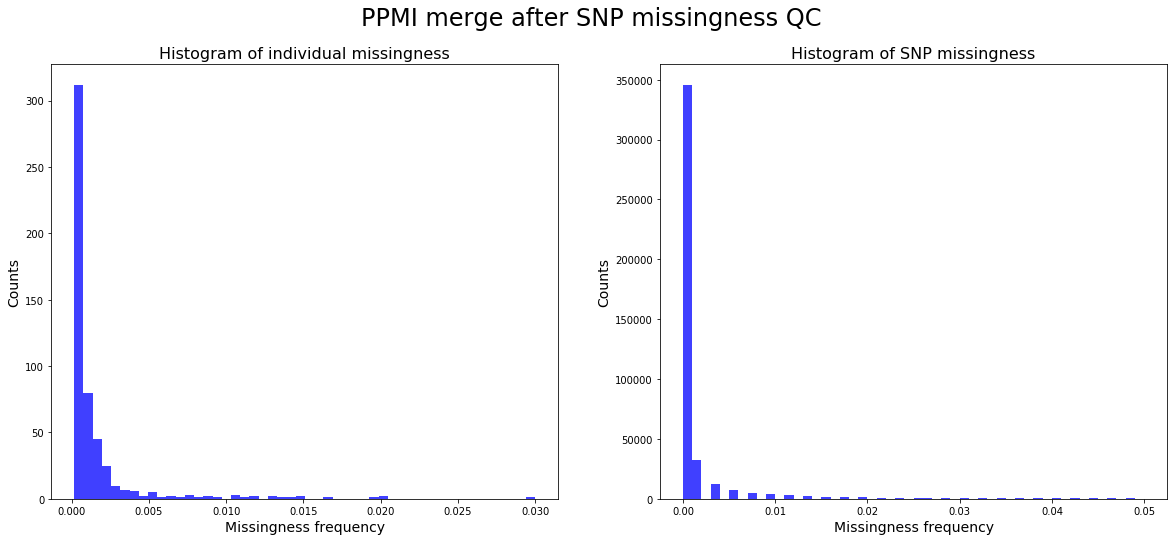

In [12]:
ppmi_indmiss = pd.read_csv(
    ".".join(["_".join([ppmi_merge_fn, "mind"]), "imiss"]),
    sep="\s+"
)
ppmi_snpmiss = pd.read_csv(
    ".".join(["_".join([ppmi_merge_fn, "mind"]), "lmiss"]),
    sep="\s+"
)

f, axes = plt.subplots(1,2, figsize=(20,8))
n, bins, patches = axes[0].hist(
    ppmi_indmiss.F_MISS.tolist(),
    50,
    facecolor="blue",
    alpha=.75
)
axes[0].set_xlabel("Missingness frequency", size=14)
axes[0].set_ylabel("Counts", size=14)
axes[0].set_title("Histogram of individual missingness", size=16)
n, bins, patches = axes[1].hist(
    ppmi_snpmiss.F_MISS.tolist(), 
    50,
    facecolor="blue", 
    alpha=.75
)
axes[1].set_xlabel("Missingness frequency", size=14)
axes[1].set_ylabel("Counts", size=14)
axes[1].set_title("Histogram of SNP missingness", size=16)
plt.suptitle("PPMI merge after SNP missingness QC", size=24)
plt.show()

### Sex discrepancies analysis

*---- Description ----*

In [10]:
!plink --bfile {"_".join([ppmi_merge_fn, "mind"])} --check-sex --out {"_".join([ppmi_merge_fn, "sexcheck"])}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_merge_sexcheck.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_merge_mind
  --check-sex
  --out ../../data/genotyping/PPMI_merge_sexcheck

16384 MB RAM detected; reserving 8192 MB for main workspace.
426108 variants loaded from .bim file.
520 people (341 males, 179 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 520 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
../../data/genotyping/PPMI_merge_sexcheck.hh ); many commands treat these as
missing.
treat these as missing.
Total genotyping rate is 0.998461.
426108 v

[[Text(0, 0, 'Males'), Text(0, 0, 'Females')]]

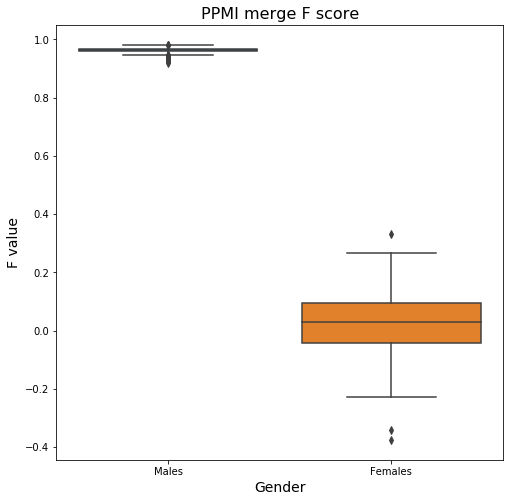

In [15]:
ppmi_checksex = pd.read_csv(
    ".".join(["_".join([ppmi_merge_fn, "sexcheck"]), "sexcheck"]),
    sep="\s+"
)

plt.figure(figsize=(8,8))
p = sns.boxplot(data=ppmi_checksex, x="PEDSEX", y="F")  # males should have F > 0.8 and females < 0.2
plt.xlabel("Gender", size=14)
plt.ylabel("F value", size=14)
plt.title("PPMI merge F score", size=16)
p.set(xticklabels=["Males", "Females"])

In [16]:
np.all(np.array(ppmi_checksex[ppmi_checksex.STATUS == "PROBLEM"].PEDSEX.tolist()) == 2)  # problems all females: expected!

True

In [17]:
subj_problem_fn = "../../data/genotyping/subjs_toremove.txt"
ppmi_checksex[ppmi_checksex.STATUS == "PROBLEM"].iloc[:,0:2].to_csv(
    subj_problem_fn,
    sep=" ",
    index=False
)

!plink --bfile {"_".join([ppmi_merge_fn, "mind"])} --remove {subj_problem_fn} --make-bed --out {"_".join([ppmi_merge_fn, "qc_subjs"])}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_merge_qc_subjs.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_merge_mind
  --make-bed
  --out ../../data/genotyping/PPMI_merge_qc_subjs
  --remove ../../data/genotyping/subjs_toremove.txt

16384 MB RAM detected; reserving 8192 MB for main workspace.
426108 variants loaded from .bim file.
520 people (341 males, 179 females) loaded from .fam.
--remove: 511 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 511 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
../../data/genotyping/PPMI_merge_qc_subjs.hh ); many commands treat th

In [19]:
!plink --bfile {"_".join([ppmi_merge_fn, "qc_subjs"])} --autosome --make-bed --out {"_".join([ppmi_merge_fn, "autosome"])}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_merge_autosome.log.
Options in effect:
  --autosome
  --bfile ../../data/genotyping/PPMI_merge_qc_subjs
  --make-bed
  --out ../../data/genotyping/PPMI_merge_autosome

16384 MB RAM detected; reserving 8192 MB for main workspace.
417404 out of 426108 variants loaded from .bim file.
511 people (341 males, 170 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 511 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.998475.
417404 variants and 511 people pass filters and QC.
Note: No phenotypes present.
--make-

### Minor Allele Frequency (MAF) QC 

*---- Description ----*

In [21]:
!plink --bfile {"_".join([ppmi_merge_fn, "autosome"])} --freq --out {"_".join([ppmi_merge_fn, "freq"])}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_merge_freq.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_merge_autosome
  --freq
  --out ../../data/genotyping/PPMI_merge_freq

16384 MB RAM detected; reserving 8192 MB for main workspace.
417404 variants loaded from .bim file.
511 people (341 males, 170 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 511 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.998475.
--freq: Allele frequencies (founders only) written to
../../data/genotyping/PPMI_merge_freq.frq .


Text(0.5, 1.0, 'Histogram of MAF (PPMI merge)')

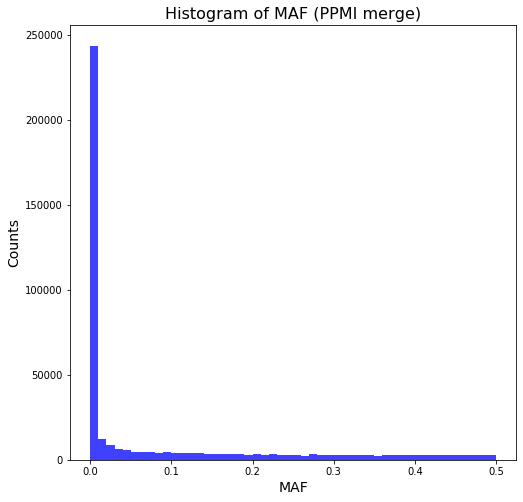

In [22]:
ppmi_freq = pd.read_csv(
    ".".join(["_".join([ppmi_merge_fn, "freq"]), "frq"]),
    sep="\s+"
)

plt.figure(figsize=(8,8))
n, bins, patches = plt.hist(
    ppmi_freq.MAF.tolist(), 
    50,
    facecolor="blue", 
    alpha=0.75
)
plt.xlabel("MAF", size=14)
plt.ylabel("Counts", size=14)
plt.title("Histogram of MAF (PPMI merge)", size=16)

In [27]:
!plink --bfile {"_".join([ppmi_merge_fn, "autosome"])} --maf 0.005 --make-bed --out {"_".join([ppmi_merge_fn, "maf"])}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_merge_maf.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_merge_autosome
  --maf 0.005
  --make-bed
  --out ../../data/genotyping/PPMI_merge_maf

16384 MB RAM detected; reserving 8192 MB for main workspace.
417404 variants loaded from .bim file.
511 people (341 males, 170 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 511 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.998475.
231264 variants removed due to minor allele threshold(s)
(--maf/--max-maf/--mac/--max-mac).
186140 variants and

### Filter SNPs not following Hardy Weinberg equilibrium (HWE)

*---- Description ----*

In [29]:
!plink --bfile {"_".join([ppmi_merge_fn, "maf"])} --hardy --out {"_".join([ppmi_merge_fn, "maf"])}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_merge_maf.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_merge_maf
  --hardy
  --out ../../data/genotyping/PPMI_merge_maf

16384 MB RAM detected; reserving 8192 MB for main workspace.
186140 variants loaded from .bim file.
511 people (341 males, 170 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 511 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.997737.
--hardy: Writing Hardy-Weinberg report (founders only) to
../../data/genotyping/PPMI_merge_maf.hwe ... 101112131415161718192021222324

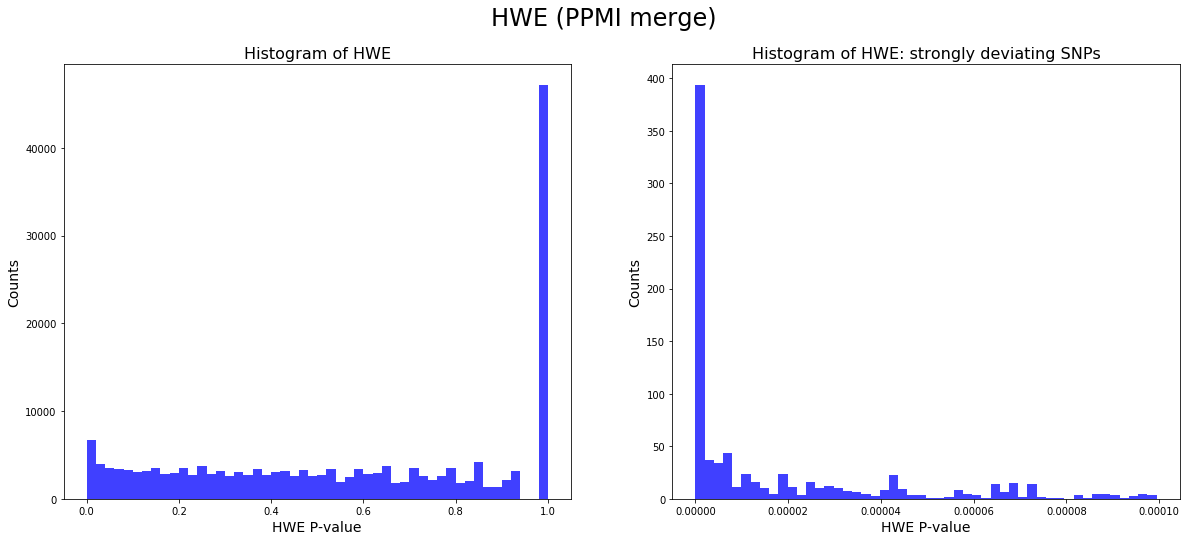

In [32]:
ppmi_hwe = pd.read_csv(
    ".".join(["_".join([ppmi_merge_fn, "maf"]), "hwe"]),
    sep="\s+"
)

f, axes = plt.subplots(1,2, figsize=(20,8))
n, bins, patches = axes[0].hist(
    ppmi_hwe.P.tolist(),
    50,
    facecolor="blue",
    alpha=.75
)
axes[0].set_xlabel("HWE P-value", size=14)
axes[0].set_ylabel("Counts", size=14)
axes[0].set_title("Histogram of HWE", size=16)
n, bins, patches = axes[1].hist(
    ppmi_hwe[ppmi_hwe.P < 1e-4].P.tolist(), 
    50,
    facecolor="blue", 
    alpha=.75
)
axes[1].set_xlabel("HWE P-value", size=14)
axes[1].set_ylabel("Counts", size=14)
axes[1].set_title("Histogram of HWE: strongly deviating SNPs", size=16)
plt.suptitle("HWE (PPMI merge)", size=24)
plt.show()

In [28]:
!plink --bfile {"_".join([ppmi_merge_fn, "maf"])} --hwe 1e-6 --make-bed --out {"_".join([ppmi_merge_fn, "hwe"])}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_merge_hwe.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_merge_maf
  --hwe 1e-6
  --make-bed
  --out ../../data/genotyping/PPMI_merge_hwe

16384 MB RAM detected; reserving 8192 MB for main workspace.
186140 variants loaded from .bim file.
511 people (341 males, 170 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 511 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.997737.
--hwe: 353 variants removed due to Hardy-Weinberg exact test.
185787 variants and 511 people pass filters and QC.
Not

### Remove ambiguous SNPs

*---- Description ----*

In [78]:
ppmi_merge_bim = pd.read_csv(
    "_".join([ppmi_merge_fn, "hwe.bim"]),
    sep="\t",
    header=None
)
bad1 = ppmi_merge_bim[(ppmi_merge_bim.iloc[:,4] == 'A') & (ppmi_merge_bim.iloc[:,5] == 'T')]
bad2 = ppmi_merge_bim[(ppmi_merge_bim.iloc[:,4] == 'T') & (ppmi_merge_bim.iloc[:,5] == 'A')]
bad3 = ppmi_merge_bim[(ppmi_merge_bim.iloc[:,4] == 'C') & (ppmi_merge_bim.iloc[:,5] == 'G')]
bad4 = ppmi_merge_bim[(ppmi_merge_bim.iloc[:,4] == 'G') & (ppmi_merge_bim.iloc[:,5] == 'C')]

badSnps = pd.concat([bad1, bad2, bad3, bad4])
badSnps_set = set(badSnps.iloc[:,1].values.tolist())

badsnps_fn = "../../data/genotyping/badsnps.txt"
pd.DataFrame(list(badSnps_set)).to_csv(badsnps_fn, header=False, index=False)

In [79]:
!plink --bfile {"_".join([ppmi_merge_fn, "hwe"])} --exclude {badsnps_fn} --make-bed --out {"_".join([ppmi_merge_fn, "snp"])}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_merge_snp.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_merge_hwe
  --exclude ../../data/genotyping/badsnps.txt
  --make-bed
  --out ../../data/genotyping/PPMI_merge_snp

16384 MB RAM detected; reserving 8192 MB for main workspace.
185787 variants loaded from .bim file.
511 people (341 males, 170 females) loaded from .fam.
--exclude: 164548 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 511 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.997844.
164548 variants and 511 people pass filters an

### Filter by genetic ancestry

*---- Description ---*

In [80]:
hapmap_path = "../../data/genotyping/HapMap3_b37/"
hapmap_bim_fn = os.path.join(hapmap_path, "HM3_b37.bim")

In [81]:
hapmap_bim = pd.read_csv(
    hapmap_bim_fn,
    sep="\t",
    header=None
)
hapmap_bim.head(n=10)

,0,1,2,3,4,5
0,1,rs3131972,0,752721,A,G
1,1,rs3131969,0,754182,A,G
2,1,rs3131967,0,754334,T,C
3,1,rs1048488,0,760912,C,T
4,1,rs12562034,0,768448,A,G
5,1,rs4040617,0,779322,G,A
6,1,rs4970383,0,838555,A,C
7,1,rs4475691,0,846808,T,C
8,1,rs1806509,0,853954,A,C
9,1,rs7537756,0,854250,G,A


In [82]:
#function to rename snps as chrom:pos_WT_AT
def rename_SNP(snpname, chrom, pos, a1, a2):
    if chrom == 0 or pos == 0:
        return snpname  # manage unmapped SNPs on neurox
    return ":".join([str(chrom), "_".join([str(pos), str(a1), str(a2)])])

hapmap_bim[6] = hapmap_bim.apply(lambda x : rename_SNP(x[1], x[0], x[3], x[4], x[5]), axis=1)
pd.DataFrame(
    zip(hapmap_bim.iloc[:,1].tolist(), hapmap_bim.iloc[:,6].tolist())
).to_csv(
    os.path.join(hapmap_path, "namemap.txt"),
    sep=" ",
    index=False,
    header=False
)
hapmap_bim.head(n=10)

,0,1,2,3,4,5,6
0,1,rs3131972,0,752721,A,G,1:752721_A_G
1,1,rs3131969,0,754182,A,G,1:754182_A_G
2,1,rs3131967,0,754334,T,C,1:754334_T_C
3,1,rs1048488,0,760912,C,T,1:760912_C_T
4,1,rs12562034,0,768448,A,G,1:768448_A_G
5,1,rs4040617,0,779322,G,A,1:779322_G_A
6,1,rs4970383,0,838555,A,C,1:838555_A_C
7,1,rs4475691,0,846808,T,C,1:846808_T_C
8,1,rs1806509,0,853954,A,C,1:853954_A_C
9,1,rs7537756,0,854250,G,A,1:854250_G_A


In [83]:
!plink --bfile {os.path.join(hapmap_path, "HM3_b37")} --update-name {os.path.join(hapmap_path, "namemap.txt")} --make-bed --out {os.path.join(hapmap_path, "HM3_b37_renamed")}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/HapMap3_b37/HM3_b37_renamed.log.
Options in effect:
  --bfile ../../data/genotyping/HapMap3_b37/HM3_b37
  --make-bed
  --out ../../data/genotyping/HapMap3_b37/HM3_b37_renamed
  --update-name ../../data/genotyping/HapMap3_b37/namemap.txt

16384 MB RAM detected; reserving 8192 MB for main workspace.
995932 variants loaded from .bim file.
988 people (488 males, 500 females) loaded from .fam.
--update-name: 995932 values updated.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 988 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.997669.

In [84]:
hapmap_bim = pd.read_csv(
    os.path.join(hapmap_path, "HM3_b37_renamed.bim"),
    sep="\t",
    header=None
)
hapmap_bim.head(n=10)

,0,1,2,3,4,5
0,1,1:752721_A_G,0,752721,A,G
1,1,1:754182_A_G,0,754182,A,G
2,1,1:754334_T_C,0,754334,T,C
3,1,1:760912_C_T,0,760912,C,T
4,1,1:768448_A_G,0,768448,A,G
5,1,1:779322_G_A,0,779322,G,A
6,1,1:838555_A_C,0,838555,A,C
7,1,1:846808_T_C,0,846808,T,C
8,1,1:853954_A_C,0,853954,A,C
9,1,1:854250_G_A,0,854250,G,A


In [88]:
ppmi_merge_bim = pd.read_csv(
    "_".join([ppmi_merge_fn, "snp.bim"]),
    sep="\t",
    header=None
)
A = set(ppmi_merge_bim.iloc[:,1].tolist())
B = set(hapmap_bim.iloc[:,1].tolist())
hp_snps = A.intersection(B)
pd.DataFrame(list(hp_snps)).to_csv(
    "../../data/genotyping/common_snps.txt",
    index=False,
    header=False
)

In [89]:
hp_fn = "../../data/genotyping/PPMI_HM"
!plink --bfile {"_".join([ppmi_merge_fn, "snp"])} --bmerge {os.path.join(hapmap_path, "HM3_b37_renamed")} --extract ../../data/genotyping/common_snps.txt --make-bed --out {hp_fn} 

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_HM.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_merge_snp
  --bmerge ../../data/genotyping/HapMap3_b37/HM3_b37_renamed
  --extract ../../data/genotyping/common_snps.txt
  --make-bed
  --out ../../data/genotyping/PPMI_HM

16384 MB RAM detected; reserving 8192 MB for main workspace.
511 people loaded from ../../data/genotyping/PPMI_merge_snp.fam.
988 people to be merged from
../../data/genotyping/HapMap3_b37/HM3_b37_renamed.fam.
Of these, 988 are new, while 0 are present in the base dataset.
164548 markers loaded from ../../data/genotyping/PPMI_merge_snp.bim.
995932 markers to be merged from
../../data/genotyping/HapMap3_b37/HM3_b37_renamed.bim.
Of these, 950375 are new, while 45557 are present in the base dataset.
14534 more same-position warnings: see log file.
Performing singl

In [90]:
!plink --bfile {hp_fn} --geno 0.1 --maf 0.05 --make-bed --out {"_".join([hp_fn, "qc"])}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_HM_qc.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_HM
  --geno 0.1
  --maf 0.05
  --make-bed
  --out ../../data/genotyping/PPMI_HM_qc

16384 MB RAM detected; reserving 8192 MB for main workspace.
43605 variants loaded from .bim file.
1499 people (829 males, 670 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 1499 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.997981.
0 variants removed due to missing genotype data (--geno).
318 variants removed due to minor allele threshold(s)
(--maf

In [91]:
!plink --bfile {"_".join([hp_fn, "qc"])} --pca 20 --out {"_".join([hp_fn, "qc"])} 

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_HM_qc.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_HM_qc
  --out ../../data/genotyping/PPMI_HM_qc
  --pca 20

16384 MB RAM detected; reserving 8192 MB for main workspace.
43287 variants loaded from .bim file.
1499 people (829 males, 670 females) loaded from .fam.
Using up to 15 threads (change this with --threads).
Before main variant filters, 1499 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.997992.
43287 variants and 1499 people pass filters and QC.
Note: No phenotypes present.
Relationship matrix calculation complete.
--pca: Results saved to

In [92]:
hp_pca = pd.read_csv(
    "_".join([hp_fn, "qc.eigenvec"]),
    sep=" ",
    header=None
)
cnames = ['FID','IID']
for i in range(1,21):
    cnames.append("PC"+str(i))
hp_pca.columns = cnames
hp_pca.head()

,FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,3000,3000,0.014210,-0.022345,0.005320,-0.007835,0.007207,0.013398,0.010624,-0.005040,...,-0.029392,-0.020252,-0.029151,0.012087,-0.003609,0.015258,0.041054,-0.053705,0.037820,-0.011176
1,3001,3001,0.014270,-0.022720,0.009661,0.002346,0.008865,0.003430,-0.002293,-0.011251,...,-0.006367,0.007539,-0.006632,0.024481,-0.050045,0.014510,0.023611,0.029970,-0.015647,-0.001085
2,3002,3002,0.013729,-0.019743,0.007746,0.004193,0.012174,0.007181,-0.058848,-0.015564,...,-0.029482,0.016489,0.008861,0.036223,0.001946,0.005699,0.022726,-0.016630,0.032326,0.009665
3,3004,3004,0.015431,-0.022605,0.005886,-0.007513,0.010261,0.002489,0.016979,0.004296,...,0.002760,0.011113,-0.019690,0.000768,-0.015339,-0.029343,0.016425,0.027190,0.031499,0.003579
4,3006,3006,0.016219,-0.018950,-0.000542,-0.002795,0.003024,0.022207,0.004172,0.036035,...,-0.047005,0.010687,0.019636,-0.030132,-0.014366,-0.023885,0.030998,0.043189,-0.023353,0.030022


In [93]:
def assign_pop(pop):
    if pop.isdigit():
        return "PPMI"
    return pop
hp_pca["FID"] = hp_pca.apply(lambda x : assign_pop(x[0]), axis=1)
hp_pca.head()

,FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,PPMI,3000,0.014210,-0.022345,0.005320,-0.007835,0.007207,0.013398,0.010624,-0.005040,...,-0.029392,-0.020252,-0.029151,0.012087,-0.003609,0.015258,0.041054,-0.053705,0.037820,-0.011176
1,PPMI,3001,0.014270,-0.022720,0.009661,0.002346,0.008865,0.003430,-0.002293,-0.011251,...,-0.006367,0.007539,-0.006632,0.024481,-0.050045,0.014510,0.023611,0.029970,-0.015647,-0.001085
2,PPMI,3002,0.013729,-0.019743,0.007746,0.004193,0.012174,0.007181,-0.058848,-0.015564,...,-0.029482,0.016489,0.008861,0.036223,0.001946,0.005699,0.022726,-0.016630,0.032326,0.009665
3,PPMI,3004,0.015431,-0.022605,0.005886,-0.007513,0.010261,0.002489,0.016979,0.004296,...,0.002760,0.011113,-0.019690,0.000768,-0.015339,-0.029343,0.016425,0.027190,0.031499,0.003579
4,PPMI,3006,0.016219,-0.018950,-0.000542,-0.002795,0.003024,0.022207,0.004172,0.036035,...,-0.047005,0.010687,0.019636,-0.030132,-0.014366,-0.023885,0.030998,0.043189,-0.023353,0.030022


Text(0, 0.5, 'PC2')

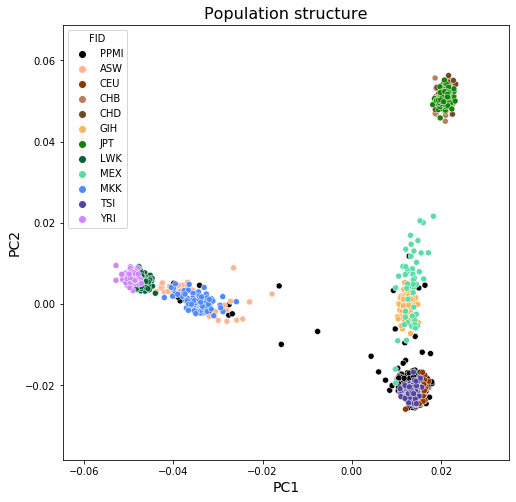

In [121]:
palette = [
    "#000000", 
    "#fbb696", 
    "#913502", 
    "#b48060", 
    "#724a20", 
    "#ffb55f", 
    "#108300", 
    "#006435", 
    "#59dda7", 
    "#508aff", 
    "#53459f", 
    "#cd87ff"
]
plt.figure(figsize=(8,8))
sns.scatterplot(data=hp_pca, x="PC1", y="PC2", hue="FID", palette=palette)
plt.title("Population structure", size=16)
plt.xlabel("PC1", size=14)
plt.ylabel("PC2", size=14)

In [95]:
# we measure the distance from the central european cluster (CEU) and italian (TSI)
hp_ceu = hp_pca[(hp_pca.FID =='CEU') | (hp_pca.FID =='TSI')]
ceu_means = hp_ceu.loc[:,'PC1':'PC5'].apply(np.mean)
ceu_sds   = hp_ceu.loc[:,'PC1':'PC5'].apply(np.std)

#compute z-scores for PPMI subjects
ppmi_pca = hp_pca[hp_pca.FID == "PPMI"]
ppmi_ceu_z = ppmi_pca.loc[:,'PC1':'PC5'].apply(lambda x: (x - ceu_means)/ceu_sds, axis=1)

ppmi_ceu_z.head()

,PC1,PC2,PC3,PC4,PC5
0,0.051475,-0.433517,-0.340325,-0.998191,0.144918
1,0.099517,-0.676873,0.182241,0.267701,0.306378
2,-0.334387,1.253446,-0.048298,0.497374,0.628533
3,1.030849,-0.602304,-0.272123,-0.958198,0.442223
4,1.662938,1.767848,-1.045959,-0.371579,-0.262396


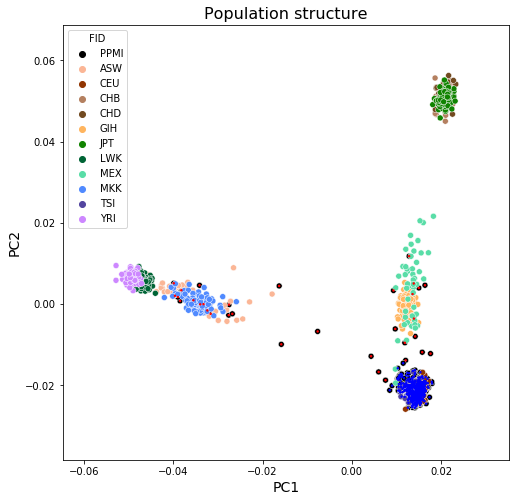

In [101]:
keep_ppmi = ppmi_ceu_z.apply(lambda x: abs(x) > 5).apply(np.sum,axis=1) == 0

ppmi_color=["b"] * len(keep_ppmi)
idx = [i for i, x in enumerate(keep_ppmi.values) if not x]
for i in idx:
    ppmi_color[i] = "r"

cuse = hp_pca.apply(lambda x: "#000000", axis=1)
plt.figure(figsize=(8,8))
sns.scatterplot(data=hp_pca, x="PC1", y="PC2", hue="FID", palette=palette)
plt.scatter(ppmi_pca.PC1, ppmi_pca.PC2, s=2, c=ppmi_color)
plt.title("Population structure", size=16)
plt.xlabel("PC1", size=14)
plt.ylabel("PC2", size=14)
plt.show()

In [105]:
ppmi_pca_ceu = ppmi_pca[keep_ppmi]
pd.DataFrame(
    zip(ppmi_pca_ceu.IID.tolist(), ppmi_pca_ceu.IID.tolist())
).to_csv(
    "../../data/genotyping/ceu_subjs.txt",
    sep=" ",
    index=False,
    header=False
)

!plink --bfile {"_".join([ppmi_merge_fn, "snp"])} --keep ../../data/genotyping/ceu_subjs.txt --make-bed --out {"_".join([ppmi_merge_fn, "ceu"])}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_merge_ceu.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_merge_snp
  --keep ../../data/genotyping/ceu_subjs.txt
  --make-bed
  --out ../../data/genotyping/PPMI_merge_ceu

16384 MB RAM detected; reserving 8192 MB for main workspace.
164548 variants loaded from .bim file.
511 people (341 males, 170 females) loaded from .fam.
--keep: 478 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 478 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate in remaining samples is 0.997877.
164548 variants and 478 people pas

### Repeat PCA on CEU subjects

In [116]:
!plink --bfile {"_".join([ppmi_merge_fn, "ceu"])} --pca 20 --out {"_".join([ppmi_merge_fn, "ceu"])}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_merge_ceu.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_merge_ceu
  --out ../../data/genotyping/PPMI_merge_ceu
  --pca 20

16384 MB RAM detected; reserving 8192 MB for main workspace.
164548 variants loaded from .bim file.
478 people (320 males, 158 females) loaded from .fam.
Using up to 15 threads (change this with --threads).
Before main variant filters, 478 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.997877.
164548 variants and 478 people pass filters and QC.
Note: No phenotypes present.
Relationship matrix calculation complete.
--pca: Resul

In [117]:
ppmi_pca_ceu = pd.read_csv(
    "_".join([ppmi_merge_fn, "ceu.eigenvec"]),
    sep=" ",
    header=None
)
cnames = ['FID','IID']
for i in range(1,21):
    cnames.append("PC"+str(i))
ppmi_pca_ceu.columns = cnames
ppmi_pca_ceu.head()

,FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,3000,3000,-0.010203,-0.005746,0.002845,-0.011594,-0.077257,0.008652,-0.017714,-0.009921,...,0.050032,-0.018782,-0.009778,0.009415,-0.005058,0.017424,0.084937,-0.028304,0.015188,-0.009345
1,3001,3001,-0.001017,-0.024860,0.017128,-0.001087,-0.000076,-0.071811,0.018356,0.022782,...,0.062727,0.036875,-0.111231,-0.089486,-0.025037,0.045367,-0.007514,-0.040008,-0.030413,0.001733
2,3002,3002,0.053249,0.074579,-0.007481,0.025106,-0.004945,-0.000790,0.002648,0.014216,...,0.000998,-0.023968,-0.004129,0.015935,-0.091759,0.000429,0.034996,-0.015436,0.127016,0.122908
3,3004,3004,0.001807,-0.038025,-0.017403,-0.016467,-0.041571,-0.014048,0.039630,-0.032932,...,-0.015594,0.013197,0.045937,0.079998,0.007482,-0.041868,0.060020,0.006409,0.036903,0.039349
4,3006,3006,0.017144,-0.052131,0.081961,-0.005148,-0.081574,-0.057017,0.028538,0.051136,...,-0.039430,-0.010930,-0.007847,-0.014976,0.047671,0.006945,-0.012224,-0.027288,0.029426,0.024116


In [140]:
ppmi_baseline_data_fn = "../../data/patient_data/PPMI-baseline_data.csv"
ppmi_baseline_data = pd.read_csv(ppmi_baseline_data_fn)
ppmi_baseline_data.head()

,SITE,PATNO,APPRDX,EVENT_ID,age,age_cat,gen,EDUCYRS,educ,HISPLAT,...,hemohi,urate,APOE,SNCA_rs356181,SNCA_rs3910105,APOE_e4,SNCA_rs356181_cat,SNCA_rs3910105_cat,MAPT,MAPT_cat
0,10,3000,2,BL,69.1397,3,2,18,2,2,...,1,315,e3/e3,T/T,C/C,0,3,1,H1/H2,2
1,10,3001,1,BL,65.1425,2,1,16,2,2,...,0,268,e3/e3,C/C,C/T,0,1,2,H1/H2,2
2,10,3002,1,BL,67.5781,3,2,16,2,2,...,0,202,e3/e3,C/T,C/T,0,2,2,H1/H1,1
3,10,3003,1,BL,56.7178,2,2,16,2,2,...,0,280,e4/e3,NaN,NaN,1,.,.,NaN,.
4,10,3004,2,BL,59.4137,2,1,16,2,2,...,0,434,e3/e2,C/T,C/C,0,2,1,H1/H2,2


In [141]:
ppmi_pca_ceu = ppmi_pca_ceu.merge(ppmi_baseline_data, left_on=["IID"], right_on=["PATNO"])
ppmi_pca_ceu.head(n=10)

,FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,hemohi,urate,APOE,SNCA_rs356181,SNCA_rs3910105,APOE_e4,SNCA_rs356181_cat,SNCA_rs3910105_cat,MAPT,MAPT_cat
0,3000,3000,-0.010203,-0.005746,0.002845,-0.011594,-0.077257,0.008652,-0.017714,-0.009921,...,1,315,e3/e3,T/T,C/C,0,3,1,H1/H2,2
1,3001,3001,-0.001017,-0.024860,0.017128,-0.001087,-0.000076,-0.071811,0.018356,0.022782,...,0,268,e3/e3,C/C,C/T,0,1,2,H1/H2,2
2,3002,3002,0.053249,0.074579,-0.007481,0.025106,-0.004945,-0.000790,0.002648,0.014216,...,0,202,e3/e3,C/T,C/T,0,2,2,H1/H1,1
3,3004,3004,0.001807,-0.038025,-0.017403,-0.016467,-0.041571,-0.014048,0.039630,-0.032932,...,0,434,e3/e2,C/T,C/C,0,2,1,H1/H2,2
4,3006,3006,0.017144,-0.052131,0.081961,-0.005148,-0.081574,-0.057017,0.028538,0.051136,...,0,220,e4/e3,C/T,C/C,1,2,1,H1/H2,2
5,3008,3008,-0.014738,-0.011846,-0.067086,-0.043899,0.018849,0.017790,0.002864,-0.008962,...,0,333,e3/e3,T/T,C/C,0,3,1,H1/H1,1
6,3011,3011,0.029531,0.006645,0.005107,0.035055,-0.067740,-0.032862,0.062955,0.037774,...,0,410,e3/e3,T/T,C/T,0,3,2,H1/H2,2
7,3012,3012,-0.002139,0.015282,0.007926,-0.072998,0.055480,0.036465,-0.036169,-0.028743,...,0,286,e4/e3,C/C,T/T,1,1,3,H1/H1,1
8,3016,3016,-0.022424,-0.026664,-0.071254,0.035412,0.038033,0.000232,-0.036751,0.007250,...,0,327,e3/e3,C/T,T/T,0,2,3,H1/H1,1
9,3018,3018,-0.012043,-0.022183,0.084564,0.045314,0.027094,0.049571,0.087399,0.076336,...,0,214,e3/e2,C/C,T/T,0,1,3,H1/H1,1


Text(0, 0.5, 'PC2')

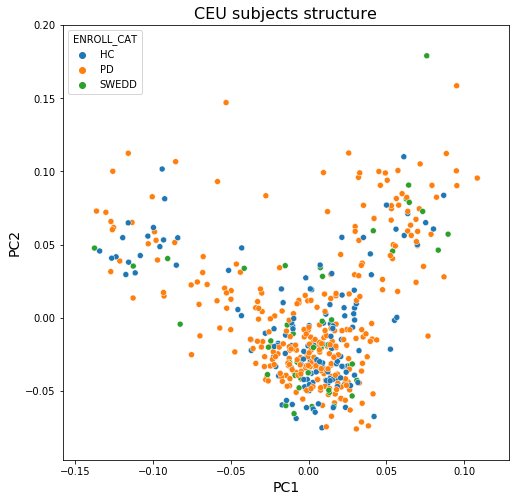

In [142]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=ppmi_pca_ceu, x="PC1", y="PC2", hue="ENROLL_CAT")
plt.title("CEU subjects structure", size=16)
plt.xlabel("PC1", size=14)
plt.ylabel("PC2", size=14)

In [125]:
ppmi_ceu_noswedd_fn = "_".join([ppmi_merge_fn, "ceu_noswedd"])
noswedd_fn = "../../data/genotyping/noswedd.txt"
ppmi_pca_ceu[ppmi_pca_ceu.ENROLL_CAT != "SWEDD"].iloc[:, 0:2].to_csv(
    noswedd_fn, 
    sep=" ", 
    index=False, 
    header=False
)

!plink --bfile {"_".join([ppmi_merge_fn, "ceu"])} --keep {noswedd_fn} --make-bed --out {"_".join([ppmi_merge_fn, "ceu_noswedd"])}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_merge_ceu_noswedd.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_merge_ceu
  --keep ../../data/genotyping/noswedd.txt
  --make-bed
  --out ../../data/genotyping/PPMI_merge_ceu_noswedd

16384 MB RAM detected; reserving 8192 MB for main workspace.
164548 variants loaded from .bim file.
478 people (320 males, 158 females) loaded from .fam.
--keep: 434 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 434 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate in remaining samples is 0.997886.
164548 variants and 

In [126]:
!plink --bfile {"_".join([ppmi_merge_fn, "ceu_noswedd"])} --pca 20 --out {"_".join([ppmi_merge_fn, "ceu_noswedd"])}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_merge_ceu_noswedd.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_merge_ceu_noswedd
  --out ../../data/genotyping/PPMI_merge_ceu_noswedd
  --pca 20

16384 MB RAM detected; reserving 8192 MB for main workspace.
164548 variants loaded from .bim file.
434 people (292 males, 142 females) loaded from .fam.
Using up to 15 threads (change this with --threads).
Before main variant filters, 434 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.997886.
164548 variants and 434 people pass filters and QC.
Note: No phenotypes present.
Relationship matrix calculatio

In [143]:
ppmi_baseline_data = pd.read_csv(ppmi_baseline_data_fn)
ppmi_pca_ceu_noswedd = pd.read_csv(
    ".".join(["_".join([ppmi_merge_fn, "ceu_noswedd"]), "eigenvec"]), 
    sep=" ", 
    header=None
)
# assign FID and IID
cnames = ['FID','IID']
for i in range(1, 21):
    cnames.append("PC"+str(i))
ppmi_pca_ceu_noswedd.columns = cnames

status = status[status["PATNO"].isin(ppmi_pca_ceu_noswedd.iloc[:, 1].tolist())].reset_index(drop=True)
ppmi_pca_ceu_noswedd = ppmi_pca_ceu_noswedd.merge(status, left_on=["IID"], right_on=["PATNO"])
ppmi_pca_ceu_noswedd.head()

,FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC19,PC20,PATNO,RECRUITMENT_CAT,IMAGING_CAT,ENROLL_DATE,ENROLL_CAT,ENROLL_STATUS,DESCRP_CAT,STATUS_DATE
0,3000,3000,-0.008963,0.014106,-0.013416,0.036194,0.076079,0.011929,0.025514,0.004101,...,0.011071,0.026602,3000,HC,HC,02/2011,HC,Enrolled,NaN,02/2011
1,3001,3001,-0.000889,0.031927,-0.018024,-0.011181,-0.011480,-0.076285,0.026169,-0.028695,...,-0.017328,-0.008644,3001,PD,PD,03/2011,PD,Enrolled,NaN,03/2011
2,3002,3002,0.047061,-0.074670,0.007935,-0.029273,0.018117,0.006043,-0.054037,0.034088,...,0.170216,-0.037879,3002,PD,PD,03/2011,PD,Enrolled,NaN,03/2011
3,3004,3004,0.007262,0.050841,0.005330,0.031568,0.029643,-0.022626,0.014098,0.002101,...,0.026919,-0.063116,3004,HC,HC,04/2011,HC,Enrolled,NaN,04/2011
4,3006,3006,0.020899,0.053079,-0.095603,0.009717,0.065405,-0.072160,-0.024078,-0.068976,...,0.033315,-0.003117,3006,PD,PD,05/2011,PD,Withdrew,NaN,10/2013


Text(0, 0.5, 'PC2')

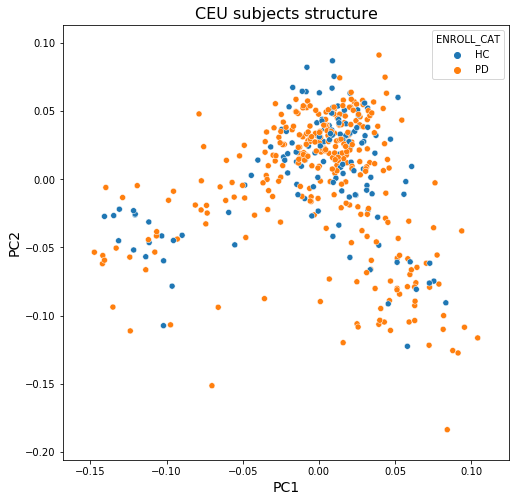

In [144]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=ppmi_pca_ceu_noswedd, x="PC1", y="PC2", hue="ENROLL_CAT")
plt.title("CEU subjects structure", size=16)
plt.xlabel("PC1", size=14)
plt.ylabel("PC2", size=14)